# 1-1 结构化数据建模流程范例

In [2]:
import torch

## 一、准备数据
titanic数据集的目标是根据乘客信息预测他们在Titanic号撞击冰山沉没后能否生存。

结构化数据一般会使用Pandas中的DataFrame进行预处理。

In [3]:
import numpy as numpy
import pandas as pd
from matplotlib import pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [4]:
# 读取数据
dftrain_raw = pd.read_csv("./data/titanic/train.csv")
dftest_raw = pd.read_csv("./data/titanic/test.csv")
# 查看数据
dftrain_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,493,0,1,"Molson, Mr. Harry Markland",male,55.0,0,0,113787,30.5000,C30,S
1,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C
2,388,1,2,"Buss, Miss. Kate",female,36.0,0,0,27849,13.0000,NaN,S
3,192,0,2,"Carbines, Mr. William",male,19.0,0,0,28424,13.0000,NaN,S
4,687,0,3,"Panula, Mr. Jaako Arnold",male,14.0,4,1,3101295,39.6875,NaN,S


上述的字段说明在eat_tensorflow_30_days中有介绍, 这里不再赘述

使用Pandas的数据可视化功能可以进行简单的探索性数据分析EDA(Exploratory Data Analysis)

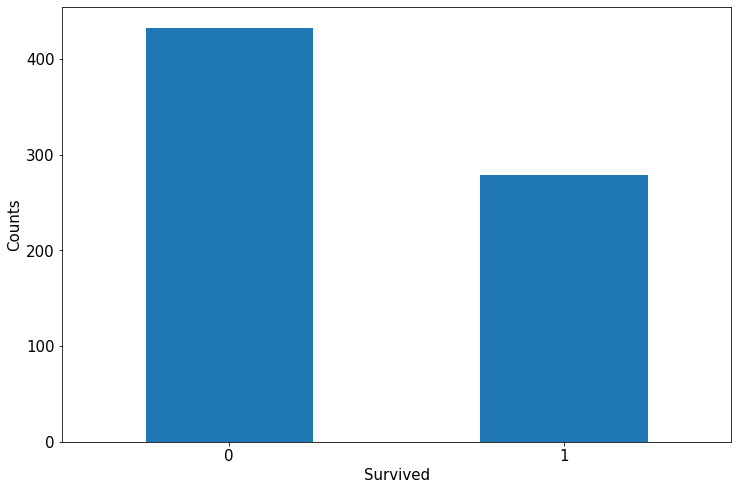

In [5]:
# label的分布情况
ax = dftrain_raw["Survived"].value_counts().plot(kind="bar", figsize=(12,8), fontsize=15, rot=0)
ax.set_ylabel("Counts", fontsize=15)
ax.set_xlabel("Survived", fontsize=15)
plt.show()

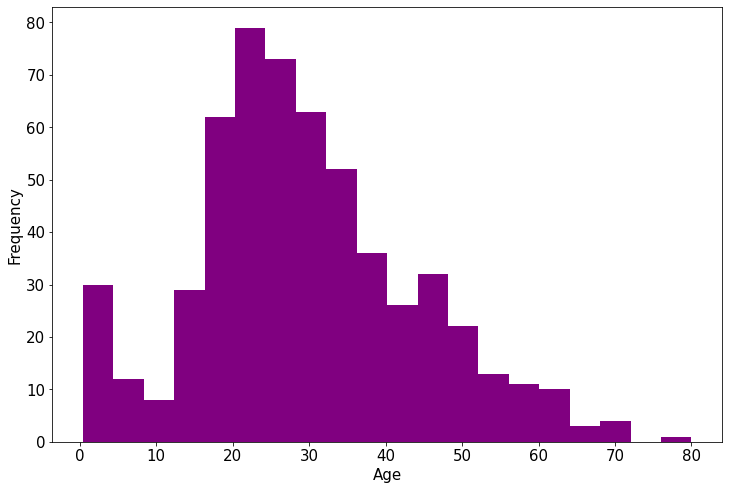

In [6]:
# 年龄的分布情况
ax = dftrain_raw["Age"].plot(kind="hist", bins=20, color="purple", figsize=(12,8), fontsize=15)
ax.set_ylabel("Frequency", fontsize=15)
ax.set_xlabel("Age", fontsize=15)
plt.show()

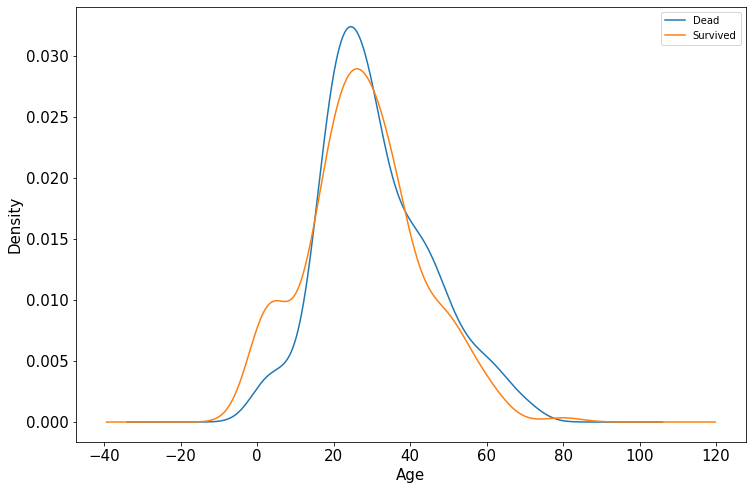

In [7]:
# 探究死亡和年龄之间的关系
ax = dftrain_raw.query("Survived == 0")["Age"].plot(kind="density", figsize=(12,8), fontsize=15)
dftrain_raw.query("Survived == 1")["Age"].plot(kind="density", figsize=(12,8), fontsize=15)
ax.legend(["Dead", "Survived"])
ax.set_ylabel("Density", fontsize=15)
ax.set_xlabel("Age", fontsize=15)
plt.show()

下面为正式的数据处理部分

In [16]:
def preprocessing(dfdata):
    dfresult = pd.DataFrame()
    # Pclass
    dfPclass = pd.get_dummies(dfdata["Pclass"], prefix="Pclass_")
    dfresult = pd.concat([dfresult, dfPclass], axis=1)  # 按照列合并

    # Sex
    dfSex = pd.get_dummies(dfdata["Sex"])
    dfresult = pd.concat([dfresult, dfSex], axis=1)

    # Age
    dfresult["Age"] = dfdata["Age"].fillna(0)
    dfresult["Age_null"] = pd.isna(dfdata["Age"]).astype("int32")

    # SibSp, Parch, Fare
    dfresult["SibSp"] = dfdata["SibSp"]
    dfresult["Parch"] = dfdata["Parch"]
    dfresult["Fare"] = dfdata["Fare"]

    # Cabin
    dfresult["Cabin_null"] = pd.isna(dfdata["Cabin"]).astype("int32")

    # Embarked
    dfEmbarked = pd.get_dummies(dfdata["Embarked"], dummy_na=True, prefix="Embarked_")
    dfresult = pd.concat([dfresult, dfEmbarked], axis=1)
    
    return dfresult

In [17]:
x_train = preprocessing(dftrain_raw).values
y_train = dftrain_raw[["Survived"]].values  # 细节, 取出的是DataFrame

In [21]:
x_test = preprocessing(dftest_raw).values
y_test = dftest_raw[["Survived"]].values

In [22]:
# 查看数据维度
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (712, 15)
y_train shape: (712, 1)
x_test shape: (179, 15)
y_test shape: (179, 1)


进一步使用DataLoader和TensorData封装成可迭代的数据管道

In [25]:
dl_train = DataLoader(TensorDataset(torch.tensor(x_train).float(), torch.tensor(y_train).float()), shuffle=True, batch_size=8)

dl_test = DataLoader(TensorDataset(torch.tensor(x_test).float(), torch.tensor(y_test).float()), shuffle=True, batch_size=8)

In [32]:
#v 测试DataLoader
for features, label in dl_train:
    print(features, label, sep="\n")
    break

tensor([[ 0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000,  8.0000,
          2.0000, 69.5500,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000],
        [ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000, 19.0000,  0.0000,  1.0000,
          0.0000, 26.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000],
        [ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000, 33.0000,  0.0000,  1.0000,
          2.0000, 27.7500,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000],
        [ 0.0000,  0.0000,  1.0000,  1.0000,  0.0000, 16.0000,  0.0000,  0.0000,
          0.0000,  7.7500,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  1.0000,  0.0000,  1.0000, 32.0000,  0.0000,  0.0000,
          0.0000, 56.4958,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000],
        [ 0.0000,  0.0000,  1.0000,  0.0000,  1.0000, 25.0000,  0.0000,  0.0000,
          0.0000,  7.2250,  1.0000,  1.0000,  0.0000,  0.0000,  0.0000],
        [ 1.0000,  0.0000,  0.0000,  0.0000,  1.0000, 28.0000,  0.0000,  0.0

## 二、定义模型
使用Pytorch常用三种方式构建模型：
* 使用nn.Sequential
* 继承nn.Module
* 继承nn.Module基类构建模型并辅助应用模型容器进行封装

在这里选择最简单的Sequential模型进行构建

In [33]:
def create_net():
    net = nn.Sequential()
    net.add_module("linear1", nn.Linear(15, 20))
    net.add_module("relu1", nn.ReLU())
    net.add_module("linear2", nn.Linear(20, 15))
    net.add_module("relu2", nn.ReLU())
    net.add_module("linear3", nn.Linear(15, 1))
    net.add_module("sigmoid", nn.Sigmoid())
    return net

In [34]:
net = create_net()

In [35]:
print(net)

Sequential(
  (linear1): Linear(in_features=15, out_features=20, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=20, out_features=15, bias=True)
  (relu2): ReLU()
  (linear3): Linear(in_features=15, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [38]:
from torchkeras import summary
summary(net, input_shape=(15,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 20]             320
              ReLU-2                   [-1, 20]               0
            Linear-3                   [-1, 15]             315
              ReLU-4                   [-1, 15]               0
            Linear-5                    [-1, 1]              16
           Sigmoid-6                    [-1, 1]               0
Total params: 651
Trainable params: 651
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.000057
Forward/backward pass size (MB): 0.000549
Params size (MB): 0.002483
Estimated Total Size (MB): 0.003090
----------------------------------------------------------------


## 三、训练模型
Pytorch通常需要用户编写自定义训练循环, 而循环的风格一般有三种:
* 脚本形式训练循环
* 函数形式训练循环
* 类形式训练循环
此处介绍一种较通用的脚本形式

In [43]:
from sklearn.metrics import accuracy_score

loss_func = nn.BCELoss()
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.01)
metric_func = lambda y_pred, y_true: accuracy_score(y_true.data.numpy(), y_pred.data.numpy()>0.5)
metric_name = "accuracy"

epochs = 10
log_step_freq = 30

dfhistory = pd.DataFrame(columns=["epoch", "loss", metric_name, "val_loss", "val_"+metric_name])
print("Start Training...")
for epoch in range(1, epochs+1):
    # 1.训练循环
    net.train()  # whether to set training mode (True) or evaluation mode (False)
    loss_sum = 0.0
    metric_sum = 0.0
    step = 1

    for step, (features, labels) in enumerate(dl_train, 1):
        # 梯度清0
        optimizer.zero_grad()

        # 正向传播求损失
        predictions = net(features)
        loss = loss_func(predictions, labels)
        metric = metric_func(predictions, labels)

        # 反向传播求梯度
        loss.backward()
        optimizer.step()

        # 打印batch级别日志
        loss_sum += loss.item()
        metric_sum += metric.item()
        if step % log_step_freq == 0:
            print("[step = {:d}] loss: {:.3f}, {}: {:.3f}".format(step, loss_sum/step, metric_name, metric_sum/step))
    # 2. 验证循环
    net.eval()
    val_loss_sum = 0.0
    val_metric_sum = 0.0
    val_step = 1

    for val_step, (featrues, label) in enumerate(dl_test, 1):
        # 关闭梯度计算
        with torch.no_grad():
            predictions = net(features)
            val_loss = loss_func(predictions, labels)
            val_metric = metric_func(predictions, labels)
        val_loss_sum += val_loss.item()
        val_metric_sum += val_metric.item()

    # 3. 记录日志
    info = (epoch, loss_sum/step, metric_sum/step, val_loss_sum/val_step, val_metric_sum/val_step)
    dfhistory.loc[epoch-1] = info

    # 打印epoch级别日志
    print("\nEPOCH = {:d}, loss = {:.3f}, {} = {:.3f}, val_loss = {:.3f}, val_{} = {:.3f}".format(*info[0:2], metric_name, *info[2:4], metric_name, *info[4:]))

print("Finshed Training...")

Start Training...
[step = 30] loss: 0.644, accuracy: 0.725
[step = 60] loss: 0.596, accuracy: 0.738

EPOCH = 1, loss = 0.572, accuracy = 0.743, val_loss = 0.590, val_accuracy = 0.750
[step = 30] loss: 0.479, accuracy: 0.804
[step = 60] loss: 0.513, accuracy: 0.771

EPOCH = 2, loss = 0.503, accuracy = 0.778, val_loss = 0.342, val_accuracy = 0.875
[step = 30] loss: 0.571, accuracy: 0.754
[step = 60] loss: 0.530, accuracy: 0.769

EPOCH = 3, loss = 0.517, accuracy = 0.775, val_loss = 0.414, val_accuracy = 0.750
[step = 30] loss: 0.483, accuracy: 0.796
[step = 60] loss: 0.496, accuracy: 0.779

EPOCH = 4, loss = 0.491, accuracy = 0.782, val_loss = 0.676, val_accuracy = 0.625
[step = 30] loss: 0.507, accuracy: 0.779
[step = 60] loss: 0.466, accuracy: 0.804

EPOCH = 5, loss = 0.474, accuracy = 0.792, val_loss = 0.361, val_accuracy = 0.875
[step = 30] loss: 0.503, accuracy: 0.767
[step = 60] loss: 0.483, accuracy: 0.796

EPOCH = 6, loss = 0.485, accuracy = 0.792, val_loss = 0.574, val_accuracy 

## 四、评估模型


In [46]:
dfhistory

,epoch,loss,accuracy,val_loss,val_accuracy
0,1.0,0.571781,0.742978,0.589819,0.750
1,2.0,0.503260,0.778090,0.342244,0.875
2,3.0,0.516603,0.775281,0.413953,0.750
3,4.0,0.491196,0.782303,0.676378,0.625
4,5.0,0.474402,0.792135,0.360837,0.875
5,6.0,0.484712,0.792135,0.573783,0.875
6,7.0,0.476417,0.786517,0.303683,0.875
7,8.0,0.493292,0.785112,0.741841,0.750
8,9.0,0.473129,0.810393,0.215514,1.000
9,10.0,0.462292,0.792135,0.397830,0.750


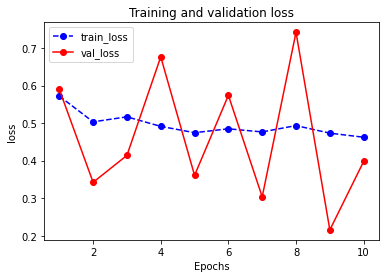

In [47]:
import matplotlib.pyplot as plt

def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()
plot_metric(dfhistory,"loss")

## 五、使用模型

In [48]:
y_pred_probs = net(torch.tensor(x_test[0:10]).float()).data
y_pred_probs

tensor([[0.1370],
        [0.6857],
        [0.4839],
        [0.9443],
        [0.5567],
        [0.8859],
        [0.0819],
        [0.8883],
        [0.5865],
        [0.1036]])

In [50]:
y_pred = torch.where(y_pred_probs>0.5, torch.ones_like(y_pred_probs), torch.zeros_like(y_pred_probs))
y_pred

tensor([[0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.]])

## 六、保存模型
Pytorch一般有两种保存模型的方式, 都是通过调用pickle实现的
* 只保存模型参数
* 保存完整模型

In [51]:
# 保存模型参数
print(net.state_dict().keys())

odict_keys(['linear1.weight', 'linear1.bias', 'linear2.weight', 'linear2.bias', 'linear3.weight', 'linear3.bias'])


In [53]:
torch.save(net.state_dict(), "./data/net_parameter.pkl")

In [54]:
# 加载模型
net_clone = create_net()
net_clone.load_state_dict(torch.load("./data/net_parameter.pkl"))

<All keys matched successfully>

In [55]:
net_clone.forward(torch.tensor(x_test[0:10]).float()).data

tensor([[0.1370],
        [0.6857],
        [0.4839],
        [0.9443],
        [0.5567],
        [0.8859],
        [0.0819],
        [0.8883],
        [0.5865],
        [0.1036]])

In [56]:
# 保存完整模型
torch.save(net, './data/net_model.pkl')
net_loaded = torch.load('./data/net_model.pkl')
net_loaded(torch.tensor(x_test[0:10]).float()).data

tensor([[0.1370],
        [0.6857],
        [0.4839],
        [0.9443],
        [0.5567],
        [0.8859],
        [0.0819],
        [0.8883],
        [0.5865],
        [0.1036]])